# 1- Import all necessary libraries for the Deep Learning project

In [ ]:
# import the necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics
import os
import glob
import tqdm

# 2- Download the dataset

In [ ]:
# download the required dataset from kaggle 

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d aseemdandgaval/23-pet-breeds-image-classification

 99% 785M/794M [00:08<00:00, 49.9MB/s]
100% 794M/794M [00:09<00:00, 92.1MB/s]


In [ ]:
!unzip 23-pet-breeds-image-classification.zip

Archive:  23-pet-breeds-image-classification.zip
  inflating: Pet_Breeds/abyssinian/abyssinian_1.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_10.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_100.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_101.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_102.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_103.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_104.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_105.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_106.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_107.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_108.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_109.jpeg  
  inflating: Pet_Breeds/abyssinian/abyssinian_11.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_110.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_111.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_112.jpg  
  inflating: Pet_Breeds/abyssinian/abyssinian_113.jpg  
  

In [ ]:
def create_dataframe(data_path):
  labels = os.listdir(data_path)
  labels_paths = {}
  for label in labels:
    labels_paths[label] = []
  for dir in os.listdir(data_path):
    for label in labels_paths:
      if dir == label:
        labels_paths[label].extend(glob.glob("/content/Pet_Breeds" + "/" +dir + "/*.jpg"))
  i = 0
  all_labels = np.array([])
  images_path = []
  for label, images in labels_paths.items():
      num_classes = []
      for num in images:
        num_classes.append(i)
      all_labels = np.concatenate([all_labels, num_classes])
      images_path += images
      i += 1
  df=pd.DataFrame({'images_path':images_path, 'labels':all_labels})
  return df


In [ ]:
df = create_dataframe("/content/Pet_Breeds")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3712 entries, 0 to 3711
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   images_path  3712 non-null   object 
 1   labels       3712 non-null   float64
dtypes: float64(1), object(1)
memory usage: 58.1+ KB


,images_path,labels
0,/content/Pet_Breeds/american shorthair/america...,0.0
1,/content/Pet_Breeds/american shorthair/america...,0.0
2,/content/Pet_Breeds/american shorthair/america...,0.0
3,/content/Pet_Breeds/american shorthair/america...,0.0
4,/content/Pet_Breeds/american shorthair/america...,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5621b923d0>]],
      dtype=object)

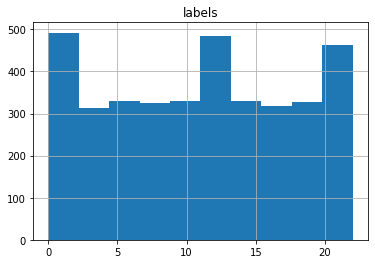

In [ ]:
df.hist()

In [ ]:
x_train,x_test,y_train,y_test = model_selection.train_test_split(df.images_path,df.labels,test_size=0.2,stratify=df.labels)

In [ ]:
# check the shape of the following (x_train, y_train and x_test, y_test)
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (2964,)
y_train shape: (2964,)
x_test shape: (742,)
y_test shape: (742,)


# 3- Make sure to convert the target into one hot vector

In [ ]:
# convert the labels to one hot vector
y_train = tf.keras.utils.to_categorical(y_train, 23)
y_test = tf.keras.utils.to_categorical(y_test, 23)

# 4- Create Data Pipeline with Data Augmentation


In [ ]:
# function to get corrupted images
import cv2
import tensorflow as tf
import os

def check_images(s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                        image_contents = tf.io.read_file(f_path)
                        image = tf.image.decode_jpeg(image_contents, channels=3)
                    except Exception as e:
                        print('file ', f_path, ' is not a valid image file')
                        print(e)
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext
source_dir = "/content/Pet_Breeds"
good_exts=['jpg','jpeg'] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')

print(bad_file_list)
print(bad_ext_list)

processing class directory  american shorthair
processing class directory  golden retriever
processing class directory  dachshund
processing class directory  ragdoll cat
processing class directory  sphynx
processing class directory  siamese cat
file  /content/Pet_Breeds/siamese cat/siamese cat_161.jpg  is not a valid image file
Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]
processing class directory  labrador
processing class directory  chihuahua
processing class directory  german shepherd
file  /content/Pet_Breeds/german shepherd/german shepherd_149.jpg  is not a valid image file
Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]
processing class directory  pomeranian
processing class directory  yorkshire terrier
processing class directory  pug
processing class directory  bulldog
processing class directory  abyssinian
file  /content/Pet_Breeds/abyssinian/abyssinian_14.jpg  is not a valid image file
Unknown image file forma

In [ ]:
import os
for corrupted in ['/content/Pet_Breeds/german shepherd/german shepherd_149.jpg', '/content/Pet_Breeds/abyssinian/abyssinian_14.jpg', '/content/Pet_Breeds/rottwiler/rottwiler_26.jpg', '/content/Pet_Breeds/beagle/beagle_11.jpg', '/content/Pet_Breeds/mumbai cat/mumbai cat_71.jpg', '/content/Pet_Breeds/siamese cat/siamese cat_161.jpg']:
  os.remove(corrupted)
  print('success')

success
success
success
success
success
success


In [ ]:
# read images file from file path
def read_images(x,y):
    x = tf.io.read_file(x)
    x = tf.io.decode_jpeg(x,channels=3)
    x = tf.image.convert_image_dtype(x,tf.float32)
    x = tf.image.resize(x,(224,224))

    return x, y
def image_aug(x,y):
    x = tf.image.random_flip_left_right(x)
    x= tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x,max_delta=32/255)
    x= tf.image.random_saturation(x,lower=0.5,upper=1.5)
    x = tf.clip_by_value(x,0.0,1.0)
    return x, y




In [ ]:
# create the data pipline 
def dataset_creater(x,y, training=False):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data =data.shuffle(1028)
    data =data.map(read_images)
    if training:
        data = data.map(image_aug)
    data =data.batch(32)
    data =data.prefetch(tf.data.AUTOTUNE)
    return data


train_dataset = dataset_creater(x_train,y_train,training=True)
test_dataset = dataset_creater(x_test,y_test)

# 5- Plot the images 

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(23,), dtype=float32)


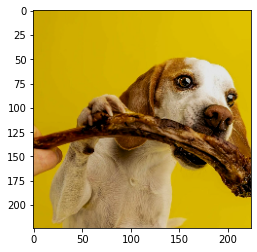

In [ ]:
# plot the augmented images 
for x,y in train_dataset.take(1):
    plt.imshow(x[0])
    print(y[0])

# 6- Modeling
**Note:**
1. Train CNN models (try ResNet architecture).
1. Make sure to separate each model in a new sub-section.
2. Use multiple Transfer Learning models.
4. Use the right evaluation metrics to choose the best model (write down your choice of the best model).

## CNN Models
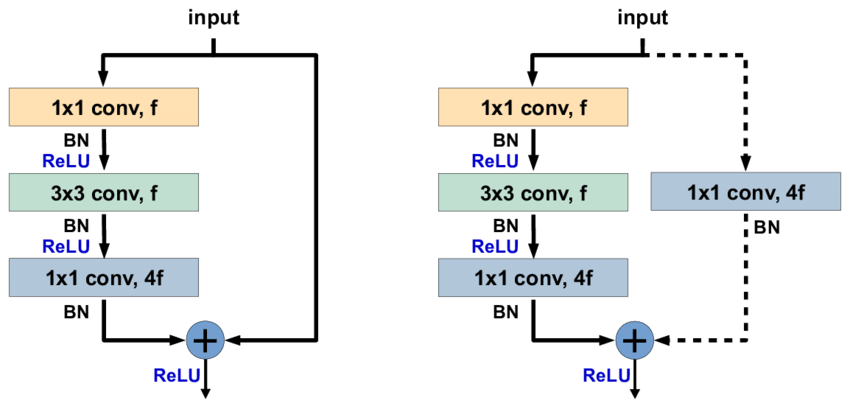

### ResNet Blocks

In [ ]:
# create the ResNet blocks 

# create the identity block 
class IdenticalBlock(tf.keras.layers.Layer):
  def __init__(self,filters,**kwargs):
    super(IdenticalBlock,self).__init__(**kwargs)
    f1,f2 = filters
    # layer 1
    self.conv_1 = tf.keras.layers.Conv2D(filters=f1,kernel_size=(1,1),use_bias=False,padding='valid')
    self.BN_conv_1 = tf.keras.layers.BatchNormalization()
    # layer 2
    self.conv_2 = tf.keras.layers.Conv2D(filters=f1,kernel_size=(3,3),use_bias=False,padding='same')
    self.BN_conv_2 = tf.keras.layers.BatchNormalization()
    # layer 3
    self.conv_3 = tf.keras.layers.Conv2D(filters=f1,kernel_size=(1,1),use_bias=False,padding='valid')
    self.BN_conv_3 = tf.keras.layers.BatchNormalization()
    # layer 4
    self.conv_4 = tf.keras.layers.Conv2D(filters=f1,kernel_size=(3,3),use_bias=False,padding='same')
    self.BN_conv_4 = tf.keras.layers.BatchNormalization()
    # layer 5
    self.conv_5 = tf.keras.layers.Conv2D(filters=f2,kernel_size=(1,1),use_bias=False,padding='valid')
    self.BN_conv_5 = tf.keras.layers.BatchNormalization()
  def call(self, inputs):
      # layer 1 
      x=self.conv_1(inputs)
      x=self.BN_conv_1(x)
      x= tf.nn.leaky_relu(x)
      #layer 2 
      x=self.conv_2(x)
      x=self.BN_conv_2(x)
      x= tf.nn.leaky_relu(x)
      # layer 3 
      x=self.conv_3(x)
      x=self.BN_conv_3(x)
      # layer 4
      x = self.conv_4(x)
      x = self.BN_conv_4(x)
      # layer 5
      x = self.conv_5(x)
      x = self.BN_conv_5(x)
      add_layer = tf.keras.layers.Add()([x,inputs])
      add_layer = tf.nn.leaky_relu(add_layer)

      return add_layer
  def build_model(self,input_shape=[244,244,3]):
      inputs=tf.keras.layers.Input(input_shape)
      return tf.keras.Model(inputs=[inputs],outputs=[self.call(inputs)])
# create the convolution block 
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self,filters,strides,**kwargs):
      super(ConvBlock,self).__init__(**kwargs)
      f1,f2= filters
      # layer 1
      self.conv_1 = tf.keras.layers.Conv2D(filters=f1,kernel_size=(1,1),use_bias=False,padding='valid')
      self.BN_conv_1 = tf.keras.layers.BatchNormalization()
      # layer 2
      self.conv_2 = tf.keras.layers.Conv2D(filters=f1,kernel_size=(3,3),use_bias=False,padding='same')
      self.BN_conv_2 = tf.keras.layers.BatchNormalization()
      # layer 3
      self.conv_3 = tf.keras.layers.Conv2D(filters=f2,kernel_size=(1,1),strides=strides,use_bias=False,padding='valid')
      self.BN_conv_3 = tf.keras.layers.BatchNormalization()
      # skip layer
      self.skip_conv = tf.keras.layers.Conv2D(filters= f2,kernel_size=(1,1),strides=strides,use_bias=False,padding='valid')
      self.BN_skip_conv = tf.keras.layers.BatchNormalization()
    def call(self, inputs):
      skip_input = inputs
      # layer 1 
      x=self.conv_1(inputs)
      x=self.BN_conv_1(x)
      x= tf.nn.leaky_relu(x)
      #layer 2 
      x=self.conv_2(x)
      x=self.BN_conv_2(x)
      x= tf.nn.leaky_relu(x)
      # layer 3 
      x=self.conv_3(x)
      x=self.BN_conv_3(x)
      # skip layer
      skip = self.skip_conv(skip_input)
      skip_bn = self.BN_skip_conv(skip)
      add_layer=tf.keras.layers.Add()([x,skip_bn])
      add_layer = tf.nn.leaky_relu(add_layer)
      return add_layer
    def build_model(self,input_shape=[244,244,3]):
      inputs=tf.keras.layers.Input(input_shape)
      return tf.keras.Model(inputs=[inputs],outputs=[self.call(inputs)])

In [ ]:
# using sub-class 
# build the model
tf.keras.backend.clear_session()
class ResNet(tf.keras.Model):
  def __init__(self,**kwargs):
        super(ResNet,self).__init__(**kwargs)
        # Block 1 
        self.input_conv = tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),use_bias=False)
        self.BN_input_conv =tf.keras.layers.BatchNormalization()
        self.maxpool_1 = tf.keras.layers.MaxPool2D()
        # block 2 
        self.identical_block_1 = IdenticalBlock([64,32],name='identical_block_1')
        # block 3
        self.identical_block_2 = IdenticalBlock([64,32],name = 'identical_block_2')
        # block 4 
        self.conv_block_1 = ConvBlock([128,64],strides=(1,1),name='conv_block_1')
        self.maxpool_2 = tf.keras.layers.MaxPool2D()
         # block 5
        self.identical_block_3 = IdenticalBlock([128,64],name='identical_block_3')
        # block 6
        self.identical_block_4 = IdenticalBlock([128,64],name = 'identical_block_4')

        self.out=tf.keras.layers.Dense(units=23, activation=tf.nn.softmax)
  def call(self,inputs):
        x = self.input_conv(inputs)
        x = self.BN_input_conv(x)
        x = self.maxpool_1(x)
        x = self.identical_block_1(x)
        x = self.identical_block_2(x)
        x = self.conv_block_1(x)
        x = self.maxpool_2(x)
        x =self.identical_block_3(x)
        x =self.identical_block_4(x)
        x= tf.keras.layers.Flatten()(x)
        out = self.out(x)
        return out
model = ResNet()
model.build([None,224,224,3])

In [ ]:
df

,images_path,labels
0,/content/Pet_Breeds/german shepherd/german she...,0.0
1,/content/Pet_Breeds/german shepherd/german she...,0.0
2,/content/Pet_Breeds/german shepherd/german she...,0.0
3,/content/Pet_Breeds/german shepherd/german she...,0.0
4,/content/Pet_Breeds/german shepherd/german she...,0.0
...,...,...
3701,/content/Pet_Breeds/pomeranian/pomeranian_162.jpg,22.0
3702,/content/Pet_Breeds/pomeranian/pomeranian_38.jpg,22.0
3703,/content/Pet_Breeds/pomeranian/pomeranian_80.jpg,22.0
3704,/content/Pet_Breeds/pomeranian/pomeranian_53.jpg,22.0


In [ ]:
model.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])
model.fit(train_dataset,epochs=10,validation_data=test_dataset)

Epoch 1/10
93/93 [==============================] - 120s 1s/step - loss: 49.3240 - acc: 0.0476 - val_loss: 6.7058 - val_acc: 0.0580
Epoch 2/10
93/93 [==============================] - 103s 1s/step - loss: 5.0700 - acc: 0.0732 - val_loss: 4.6059 - val_acc: 0.0485
Epoch 3/10
93/93 [==============================] - 102s 1s/step - loss: 4.1250 - acc: 0.1063 - val_loss: 3.2643 - val_acc: 0.0485
Epoch 4/10
93/93 [==============================] - 109s 1s/step - loss: 3.6798 - acc: 0.1420 - val_loss: 3.3673 - val_acc: 0.0957
Epoch 5/10
93/93 [==============================] - 104s 1s/step - loss: 3.4551 - acc: 0.1684 - val_loss: 3.0647 - val_acc: 0.1321
Epoch 6/10
93/93 [==============================] - 106s 1s/step - loss: 3.2577 - acc: 0.1923 - val_loss: 5.1943 - val_acc: 0.1011
Epoch 7/10
93/93 [==============================] - 105s 1s/step - loss: 3.1537 - acc: 0.2088 - val_loss: 4.9606 - val_acc: 0.1496
Epoch 8/10
93/93 [==============================] - 108s 1s/step - loss: 2.9856 - 

### ResNet Transfer Learning

In [ ]:
ResNet152V2 = tf.keras.applications.ResNet152V2(
include_top=False,input_shape=(224,224,3)
)

In [ ]:
print(len(ResNet152V2.layers))
for layer in ResNet152V2.layers[:540]:
    layer.trainable=False 
for layer in ResNet152V2.layers[540:]:
    layer.trainable=True

564


In [ ]:
tf.keras.backend.clear_session()
ResNetModel = tf.keras.Sequential([
                                   ResNet152V2,
                                   tf.keras.layers.GlobalAveragePooling2D(),
                                   tf.keras.layers.Dense(23,activation=tf.nn.softmax)

])

In [ ]:
ResNetModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 23)                47127     
                                                                 
Total params: 58,378,775
Trainable params: 8,980,503
Non-trainable params: 49,398,272
_________________________________________________________________


In [ ]:
ResNetModel.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])
ResNetModel.fit(train_dataset,epochs=5,validation_data=test_dataset)

Epoch 1/5
93/93 [==============================] - 111s 1s/step - loss: 1.3060 - acc: 0.6137 - val_loss: 12.9262 - val_acc: 0.3531
Epoch 2/5
93/93 [==============================] - 106s 1s/step - loss: 0.7107 - acc: 0.7824 - val_loss: 1.6066 - val_acc: 0.6900
Epoch 3/5
93/93 [==============================] - 104s 1s/step - loss: 0.5018 - acc: 0.8502 - val_loss: 0.7827 - val_acc: 0.8019
Epoch 4/5
93/93 [==============================] - 111s 1s/step - loss: 0.3560 - acc: 0.8893 - val_loss: 0.6774 - val_acc: 0.8154
Epoch 5/5
93/93 [==============================] - 101s 1s/step - loss: 0.2927 - acc: 0.9130 - val_loss: 0.7399 - val_acc: 0.8127


### DenseNet201  Transfer Learning

In [ ]:
DenseNet201  =  tf.keras.applications.DenseNet201 (
include_top=False,input_shape=(224,224,3)
)

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
print(len(DenseNet201 .layers))
for layer in DenseNet201 .layers[:]:
    layer.trainable=False 
# for layer in DenseNet201 .layers[600:]:
#     layer.trainable=True

707


In [ ]:
tf.keras.backend.clear_session()
DenseNet201Model = tf.keras.Sequential([
                                   DenseNet201,
                                   tf.keras.layers.GlobalAveragePooling2D(),
                                   tf.keras.layers.Dense(23,activation=tf.nn.softmax)

])

In [ ]:
DenseNet201Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 23)                44183     
                                                                 
Total params: 18,366,167
Trainable params: 44,183
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
save = tf.keras.callbacks.ModelCheckpoint('/content/Model', save_best_only=True)
DenseNet201Model.compile(optimizer=tf.optimizers.Adam(),loss=tf.losses.CategoricalCrossentropy(),metrics=['acc'])
DenseNet201Model.fit(train_dataset,epochs=5,validation_data=test_dataset, callbacks=[save])

Epoch 1/2
 8/93 [=>............................] - ETA: 51s - loss: 3.2641 - acc: 0.0586

NotFoundError: ignored

## Model evaluation

In [ ]:
# evaluate the model
print("ResNet Blocks")
print('Test loss: 5.1627') 
print('Test accuracy: 0.1685') 
print('-----------------------------------------------------')
print("ResNet Transfer Learning")
print('Test loss: 0.7399') 
print('Test accuracy: 0.8127') 
print('-----------------------------------------------------')
print("DenseNet201 Transfer Learning")
print('Test loss: 0.3807') 
print('Test accuracy: 0.8801') 

ResNet Blocks
Test loss: 5.1627
Test accuracy: 0.1685
-----------------------------------------------------
ResNet Transfer Learning
Test loss: 0.7399
Test accuracy: 0.8127
-----------------------------------------------------
DenseNet201 Transfer Learning
Test loss: 0.3807
Test accuracy: 0.8801


The Best Model is using DenseNet201 Transfer Learning